#NASLib Hands-On

##Welcome to the [NASLib](https://github.com/automl/NASLib) tutorial 📖

Awesome to have you here!

This notebook is part of the **NASLib Hands-On Session** for the [2nd AutoML Fall school](https://sites.google.com/view/automl-fall-school-2022). Before you start, please copy this notebook to your Google drive (`File` ➡ `Save a Copy in Drive`).




#[NASLib](https://github.com/automl/NASLib/) overview 🗒
NASLib is a modular and flexible framework created with the aim of providing a common codebase to the community to facilitate research on Neural Architecture Search (NAS). It offers high-level abstractions for designing and reusing search spaces, interfaces to benchmarks and evaluation pipelines, enabling the implementation and extension of several NAS methods with a few lines of code.

![](https://raw.githubusercontent.com/automl/NASLib/Develop_copy/images/naslib-overall.png)

This tutorial will focus on Neural Architecture Search and how NASLib can be leveraged to simplify it greatly.

The tutorial is divided into 4 sections:
1. [Setting up NASLib](#setup)
2. [Search Spaces in NASLib](#search_spaces)
3. [Optimizers in NASLib](#optimizers)
4. [Zero Cost Predictors in NASLib](#zcps)

<a name="setup"></a>
# 1. Setting Up NASLib 💻

We begin by setting up NASLib. First we, clone the repository and install NASLib.

In [1]:
#Setup NASLib
%cd /content
%rm -rf NASLib
!git clone -b Develop_copy https://github.com/automl/NASLib/
%cd /content/NASLib
!pip install -e . --quiet

/content
Cloning into 'NASLib'...
remote: Enumerating objects: 32063, done.
remote: Counting objects: 100% (2032/2032), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 32063 (delta 1253), reused 1913 (delta 1156), pack-reused 30031
Receiving objects: 100% (32063/32063), 549.33 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (22647/22647), done.
/content/NASLib
     |████████████████████████████████| 636 kB 5.2 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 280 kB 57.9 MB/s 
     |████████████████████████████████| 2.0 MB 59.3 MB/s 
     |████████████████████████████████| 166.7 MB 16 kB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 1.6 MB 40.3 MB/s 
     |████████████████████████████████| 634 kB 63.7 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 13.5 MB 34.1 MB/s 
     |████████████████████████████████| 

You can ignore the pip errors relating to `typing-extensions`. Run the next cell to see if NASLib has been successfully installed.

In [12]:
import sys 
sys.path.append('../')

import naslib

Next, we download a few datasets and benchmark files that we shall use in this notebook.

In [16]:
# Download benchmarks
%cd /content/NASLib
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 ImageNet16-120
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201


/content/NASLib
dataset = cifar10
search_space = nb201
cifar10 exists
dataset = cifar100
search_space = nb201
cifar100 exists
dataset = ImageNet16-120
search_space = nb201
Imagenet16 exists
Imagenet16 data exits
dataset = cifar10
search_space = nb301
nb301 full training pickle exists
search_space = nb201
nb201 file exist


If downloading the datasets using the script failed you can also download the data folder from [here](https://drive.google.com/file/d/1xjs6y2cf_mXKFjrT1auAynLMg48onQ5R/view?usp=sharing). If you need assistance, please let us know!
Download and unzip the data folder and place its contents in `NASLib/naslib/data` using the commands below

In [20]:
#Caution: Run this cell only if downloading data using the script above fails
%cd /content
!gdown 1xjs6y2cf_mXKFjrT1auAynLMg48onQ5R
!unzip -o data.zip 
%ls
%mv data/* /content/NASLib/naslib/data/
%cd /content/NASLib/

/content
Downloading...
From: https://drive.google.com/uc?id=1xjs6y2cf_mXKFjrT1auAynLMg48onQ5R
To: /content/data.zip
100% 383M/383M [00:01<00:00, 281MB/s]
Archive:  data.zip
  inflating: data/train_data_batch_1  
  inflating: __MACOSX/data/._train_data_batch_1  
  inflating: data/nb301_full_training.pickle  
  inflating: __MACOSX/data/._nb301_full_training.pickle  
  inflating: data/nb201_ImageNet16_full_training.pickle  
  inflating: __MACOSX/data/._nb201_ImageNet16_full_training.pickle  
  inflating: data/nb201_cifar10_full_training.pickle  
  inflating: __MACOSX/data/._nb201_cifar10_full_training.pickle  
  inflating: data/zc_nasbench201.json  
  inflating: __MACOSX/data/._zc_nasbench201.json  
  inflating: data/nb201_cifar100_full_training.pickle  
  inflating: __MACOSX/data/._nb201_cifar100_full_training.pickle  
  inflating: data/val_data           
  inflating: __MACOSX/data/._val_data  
data/  data.zip  __MACOSX/  NASLib/  sample_data/
/content/NASLib


With that, setup is complete. We can now move on to the next section.

<a name="search_spaces"></a>
# 2. Search Spaces in NASLib
### What is NAS Search Space?
The search space defines which architectures can be represented using a choice of operations and topologies. Incorporating prior knowledge about typical properties of architectures well-suited for a task can reduce the size of the search space and simplify the search.However, this also introduces a human bias, which may prevent finding
novel architectural building blocks that go beyond the current human knowledge.

Let us consider the [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf) search space for example. This search space consists of multiple stacked cells. Each cell is a directed acyclic graph, and each operation selected from a predefined set of possible choices. 

![](https://drive.google.com/uc?id=1Uw6InTaEWaE2gwgct6ztkLudEz7X3W2y)

### What is a NAS Benchmark?
A NAS benchmark consits of the true or estimated performance of architectures from a NAS Search space each of which are evaluated on a fixed train-val-test aplit of the dataset and a fixed training pipeline. There are primarily two types of NAS benchmarks: a ***surrogate NAS benchmark*** and a ***tabular*** NAS benchmark. 

A surrogate benchmark uses a surrogate model (eg: a neural network) to predict the performance of an architecture from the search space. On the other hand a tabular benchmark queries the actual performance of an architecture trained upto convergence.

### Why do we need NAS Benchmarks?

1.   Neural architecture search often requires large computational resources. Evaluating a single model required one full training of a network
2.   Reproducibility in NAS research 

###NASLib supports multiple search spaces and benchmarks like:

1. [NAS-Bench-101](https://arxiv.org/pdf/1902.09635.pdf)
2. [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf)
3. [NAS-Bench-301](https://arxiv.org/pdf/2008.09777.pdf)
4. [TransNAS-Bench-101](https://arxiv.org/pdf/2105.11871.pdf)

### With a unified API, NASLib allows you to trivially perform several operations, such as:

1. Sample a random model from the search space, which you can use as an actual PyTorch model
2. Query the Benchmark APIs of models for metrics such as training and validation accuracies
3. Convert between different representations of a given architecture
4. Mutate an architecture

In the next part of the tutorial, we walk through each of these functionalities.



In [13]:
# Import the search space
from naslib.search_spaces import NasBench201SearchSpace

In [14]:
# Create a new search space object.
# This object doesn't have an architecture assigned to it yet - it represents the entire search space
graph = NasBench201SearchSpace(n_classes=10) # CIFAR-10 dataset requires 10 classes

In [15]:
# Sample a random architecture
# You can call this method only once on any instance
graph.sample_random_architecture()
graph.parse()

# Get the NASLib representation 
#(eg: operation index chosen at every edge) of the sampled architecture
graph.get_hash()

(0, 3, 4, 1, 2, 2)

In [16]:
# This graph is now a NAS-Bench-201 model, which can be used for training
# Forward pass some dummy data through it to see it in action

import torch

x = torch.randn(5, 3, 32, 32) # (Batch_size, Num_channels, Height, Width)

logits = graph(x)

print('Shape of the logits:', logits.shape)

Shape of the logits: torch.Size([5, 10])


In [17]:
# Import code to convert NASLib graph to the original NAS-Bench-201 representation
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str as convert_naslib_nb201_to_str

# Get the string representation of this model, that the original authors of NAS-Bench-201 used
convert_naslib_nb201_to_str(graph)

'|skip_connect~0|+|nor_conv_1x1~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|'

In [18]:
# Mutating an architecture
# First, create a new child_graph
child_graph = NasBench201SearchSpace(n_classes=10)

# Call mutate on the child graph by passing the parent graph to it
child_graph.mutate(parent=graph)

# See the parent and child graph representations. Which edge was mutated?
print(f'Parent graph: {graph.get_hash()}')
print(f'Child graph : {child_graph.get_hash()}')

Parent graph: (0, 3, 4, 1, 2, 2)
Child graph : (0, 3, 1, 1, 2, 2)


In [19]:
# Now, let's load the queryable tabular NAS-Bench-201 API
# This API has the training metrics of all the 15625 models in the search space
# such as train and validation accuracies/losses at every epoch

from naslib.utils import get_dataset_api
benchmark_api = get_dataset_api(search_space='nasbench201', dataset='cifar10')

In [20]:
# With the NAS-Bench-201 API, we can now query, say, the validation performance of any NB201 model
# Without it, we would have to train the model from scratch to get this information

# First, import the Metric enum
from naslib.search_spaces.core import Metric

# Metric has, among others, these values:
# Metric.TRAIN_ACCURACY
# Metric.VAL_ACCURACY
# Metric.TRAIN_LOSS
# Metric.TEST_LOSS
# Metric.TRAIN_TIME

train_acc_parent = graph.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=benchmark_api)
val_acc_parent = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=benchmark_api)

print('Performance of parent model')
print(f'Train accuracy: {train_acc_parent:.2f}%')
print(f'Validation accuracy: {val_acc_parent:.2f}%')

Performance of parent model
Train accuracy: 99.97%
Validation accuracy: 88.47%


#Task 1: Play with NAS-Bench-301 (10 minutes)

Now that you are familiar with the operations search spaces in NASLib, we can attempt our first task. In this task, you should do the following:

1. Sample a random NAS-Bench-301 model
2. Get the NASLib and genotype representations of the model
3. Query the predicted performance of the model (loading the NB301 benchmark API might take some time)
4. Mutate the model
5. Get the NASLib and genotype representations of the model
6. Query the predicted performance of the child

All the modules you require are already imported for you.

In [21]:
from naslib.search_spaces import NasBench301SearchSpace
from naslib.search_spaces.nasbench301.conversions import convert_naslib_to_genotype as convert_naslib_nb301_to_genotype

########## START TODO ############
# TODO: 
# 1. Sample a random NAS-Bench-301 model
# 2. Get the NASLib and genotype representations of the model
# 3. Query the predicted performance of the model (loading the NB301 benchmark API might take some time)
# 4. Mutate the model
# 5. Get the NASLib and genotype representations of the model
# 6. Query the predicted performance of the child



########## END TODO ##############

<a name="optimizers"></a>
## 3. NAS Optimizers 📈

## What is a NAS Optimizer?
The search strategy details how to explore the search space to find
well-performing architectures quickly.

![](https://drive.google.com/uc?id=1e7a4LI-f7embNqUq23FwlysP6mQu63nx)

Given the different NAS benchmarks we now want to search for the optimal architectures from the search spaces. NASLib provides a uniform api to use multiple optimizers across different benchmarks. One could easily write their own optimizer and evaluate it across the different NAS benchmarks. 

## What is a performance predictor?
Performance Estimation in NAS refers to estimating the performance of a given architecture. One trivial example of this is training a candidate architecture to convergence, but this can get very expensive. Much recent research therefore focuses on developing methods that reduce the cost of these performance estimations. A [performance predictor](https://arxiv.org/pdf/2104.01177.pdf) is defined generally as any function which predicts the final accuracy or ranking of architectures, without fully training the architectures (eg: xgboost)

Some of the optimizers supported in NASLib are:


1.   [Random search](https://arxiv.org/pdf/1902.07638.pdf)
2.   [Local Search](https://arxiv.org/pdf/2004.08996.pdf)
3.   [Regularized Evolution](https://arxiv.org/pdf/1802.01548.)
4.   [BANANAS](https://arxiv.org/pdf/1910.11858.pdf)

In this section of the tutorial we will walk through the following components:


1. Searching for an architecture using [Random search (RS)](https://arxiv.org/pdf/1902.07638.pdf) on different NAS benchmarks.
2. Searching for an architecture using [Regularized Evolution (RE)](https://arxiv.org/pdf/1802.01548.pdf) and comparing it with RS
3. Searching for an architecture using [BANANAS](https://arxiv.org/pdf/1910.11858.pdf) and comparing with RE and RS.

In [12]:
# The functions below setup and run the search experiments

def update_config(config, optimizer_type, search_space_type, dataset, seed):
    # Dataset being used
    config.dataset = dataset
    
    # Directory to which the results/logs will be saved
    config.save = f"runs/{optimizer_type.__name__}/{search_space_type.__name__}/{dataset}/{seed}"
    
    # Seed used during search phase of the optimizer
    config.search.seed = seed
    
def run_optimizer(optimizer_type, search_space_type, dataset, config, seed): 
    # Update the config
    update_config(config, optimizer_type, search_space_type, dataset, seed)

    # Make the results directories
    os.makedirs(config.save + '/search', exist_ok=True)
    os.makedirs(config.save + '/eval', exist_ok=True)

    # Set up the loggers
    logger = setup_logger()
    logger.setLevel(logging.INFO)

     # See the config
    logger.info(f'Configuration is \n{config}')

    # Set up the seed
    utils.set_seed(seed)
    # Instantiate the search space
    n_classes = {
        'cifar10': 10,
        'cifar100': 100,
        'ImageNet16-120': 120
    }
    search_space = search_space_type(n_classes=n_classes[dataset])
    search_space.instantiate_model = False
    # Get the benchmark API
    logger.info('Loading Benchmark API')
    dataset_api = get_dataset_api(search_space.get_type(), dataset)
    
    # Instantiate the optimizer and adapat the search space to the optimizer
    optimizer = optimizer_type(config)
    optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

    # Create a Trainer
    trainer = Trainer(optimizer, config)

    # Perform the search
    trainer.search(report_incumbent=False)

    # Get the results of the search
    search_trajectory = trainer.search_trajectory
    print('Train accuracies:', search_trajectory.train_acc)
    print('Validation accuracies:', search_trajectory.valid_acc)
    # Get the validation performance of the best model found in the search phase
    best_model_val_acc = trainer.evaluate(dataset_api=dataset_api, metric=Metric.VAL_ACCURACY)
    best_model_val_acc

    best_model = optimizer.get_final_architecture()

    return search_trajectory, best_model, best_model_val_acc

In [13]:
# Defining plotting utils

%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import FormatStrFormatter

# plot performance vs runtime

# didn't run them long enough to do logspace here. (These experiments took surprisingly long to run)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = 'dotted'
# set up colors and plot markings
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# goes up to 24
c_max = 9
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-'] * c_max, *['--'] * c_max, *[':'] * c_max]
markers = [*['^'] * c_max, *['v'] * c_max, *['o'] * c_max]


def get_results(results, metric='valid_acc', dataset='cifar10', ug=False):
    output = []
    time = []
    for result in results:
        val_acc = result['valid_acc']
        surr_time = np.array(result['runtime'])
        if ug:
            runtime = 200 * np.array(result['train_time']) + surr_time
        else:
            runtime = np.array(result['train_time']) + surr_time
        val_err = [100 - x for x in val_acc]
        val_incumbent = [
            min(val_err[:epoch]) for epoch in range(1,
                                                    len(val_err) + 1)
        ]
        runtime = [
            sum(runtime[:epoch]) for epoch in range(1,
                                                    len(runtime) + 1)
        ]
        if metric == 'valid_acc':
            incumbent = val_incumbent
        elif metric == 'test_acc':
            test_err = [100 - x for x in result['test_acc']]
            inc_idx, best, best_idx = [], np.inf, 0
            for i, err in enumerate(val_err):
                if err < best:
                    best, best_idx = err, i
                    inc_idx.append(best_idx)
                    incumbent = [test_err[idx] for idx in inc_idx]
        output.append(incumbent)
        time.append(runtime)
    output = np.array(output)
    time = np.array(runtime)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(
        np.var(output, axis=0, ddof=1) / np.asarray(output).shape[0])
    return mean, std, std_error, time


def plot_optimizers(trajectories,benchmark):
    plot_zoomed = False
    plot_sem = True
    fig, ax = plt.subplots(figsize=[10, 5])
    if plot_zoomed:
        sub_axes = plt.axes([.6, .6, .25, .25])
    i = 0
    for optimizer in trajectories.keys():
        mean, std, std_error, time = get_results(trajectories[optimizer])
        results_dict = {}
        results_dict = {
            'label': optimizer,
            'mean': mean,
            'runtime': time,
            'std_error': std_error
        }
        mean = results_dict['mean']
        #print(mean.shape)
        x = results_dict['runtime']
        #print(x.shape)
        sem = results_dict['std_error']
        #print(sem.shape)
        label = results_dict["label"]
        ax.plot(x, mean, label=label, color=colors[i], linestyle=fmts[i])
        ax.fill_between(x,
                        mean - 1 * sem,
                        mean + 1 * sem,
                        color=colors[i],
                        alpha=0.2)
        i = i + 1
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xscale('log')
    ax.legend(loc=(1.04, 0))
    ax.set_xlabel('Runtime [s] (simulated)')
    ax.set_ylabel('Test error (%)')
    ax.grid(True, which="both", ls="-", alpha=.5)
    ax.set_title('Test error vs. train time on '+benchmark)


  


### Random Search
1. Sample an architecture for every epoch and compute its validation error 
2. Select the architecture with the lowest validation error and return its test error

In [14]:
#initialize trajectories for RS
trajectories_rs = {}

In [19]:
#imports we will use throught this section
import json
import logging
import os

# import the Trainer used to run the optimizer on a given search space
from naslib.defaults.trainer import Trainer
# import the optimizers
from naslib.optimizers import (
    RandomSearch,
    RegularizedEvolution,
    Bananas
)
# import the search spaces
from naslib.search_spaces import (
    NasBench101SearchSpace,
    NasBench201SearchSpace,
    NasBench301SearchSpace,
)

from naslib.search_spaces.core.query_metrics import Metric
from naslib import utils
from naslib.utils import get_dataset_api
from naslib.utils import setup_logger

from fvcore.common.config import CfgNode 

In [20]:
# Set the optimizer and search space types
# They will be instantiated inside run_optimizer
optimizer_type = RandomSearch # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 200,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode.load_cfg(json.dumps(config))
#Initialize trajectories for the 3 seeds
trajectories_rs["RS"] = []
for seed in [333,444,555]: #Run RS for 3 seeds
  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed
                                                    )
  trajectories_rs["RS"].append(search_trajectory)

[09/16 10:17:07 naslib]: Configuration is 
dataset: cifar10
save: runs/RandomSearch/NasBench201SearchSpace/cifar10/333
search:
  checkpoint_freq: 200
  epochs: 100
  fidelity: -1
  population_size: 30
  sample_size: 10
  seed: 333
[09/16 10:17:07 naslib]: Loading Benchmark API
[09/16 10:17:08 nl.defaults.trainer]: Beginning search
[09/16 10:17:08 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[09/16 10:17:08 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[09/16 10:17:09 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[09/16 10:17:09 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[09/16 10:17:09 nl.defaults.trainer]: Epoch 4 done. Train accuracy: 99.92000, Validation accuracy: 89.14000
[09/16 10:17:09 nl.defaults.trainer]: Epoch 5 done. Train accuracy: 99.98800, Validation accuracy: 90.01000
[09/16 10:17:09 nl.

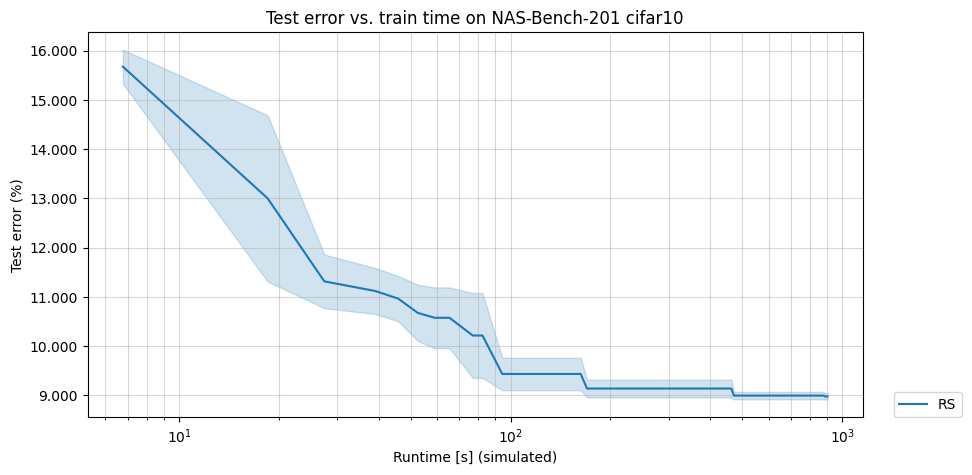

In [21]:
# Plot RS for three seeds
plot_optimizers(trajectories_rs,"NAS-Bench-201 cifar10")

### TASK 2: Search using the Regularized Evolution Optimizer
1. Search using the Regularized Evolution Optimizer for 100 epochs
2. Use NASBench301 search space with cifar10 dataset
2. Plot the search trajectories of RE for cifar10

## Regularized Evolution
![](https://drive.google.com/uc?id=11rF0ZQSoth4dMe8G5tmdemw2WBmXBerF)


In [31]:
trajectories_re= {}

In [ ]:
# TODO:
# 1. Use the Regularized Evolution optimizer instead of RandomSearch 
# 2. Use the NASBench301SearchSpace for cifar100 
# 3. Plot the RE search trajectory for NASBench301 and cifar10

# Set the optimizer type
optimizer_type = ...
# Set the search space type
search_space_type = ...

# Set the dataset
dataset = ... 

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode.load_cfg(json.dumps(config))
#Initialize trajectories for the 3 seeds
trajectories_re["RE"] = []
for seed in [333,444,555]: #Run RS for 3 seeds
  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed
                                                    )
  trajectories_re["RE"].append(search_trajectory)

In [ ]:
# Plot RS and RE for three seeds
plot_optimizers(trajectories_re,"NAS-Bench-301 cifar10")

### BANANAS
![](https://drive.google.com/uc?id=1KelEs9KUXpyO1MiO_jJ4b7gQSMWgJBlz)

In [46]:
#initialize the trajectory for BANANAS
trajectories_bn={}

In [47]:
# Now lets use BANANAS as a search optimizer with xgb as predictor
# Note: We are fitting a predictor preriodicaly so this is expected to be slower than RE and RS
from naslib.search_spaces.core.query_metrics import Metric
from naslib import utils
from naslib.utils import get_dataset_api
from naslib.utils.logging import setup_logger
import os
import logging
import sys
from naslib.defaults.trainer import Trainer


from fvcore.common.config import CfgNode
optimizer_type = Bananas # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

#define the predictor
predictor = 'xgb' 
for seed in [333,444,555]:
  config = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        'k':20,
        "num_init":10,
        "num_ensemble":1,
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
        "predictor_type": predictor,
        "acq_fn_type": "its",
        "acq_fn_optimization": 'random_sampling',
        "encoding_type": 'path',
        "num_arches_to_mutate":5,
        "max_mutations":1,
        "num_candidates":100
     }
   }
  config = CfgNode.load_cfg(json.dumps(config))

  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        config,
                                                        seed
                                                    )
  if "BANANAS_"+str(predictor) in trajectories_bn.keys():
    trajectories_bn["BANANAS_"+str(predictor)].append(search_trajectory)
  else: 
    trajectories_bn["BANANAS_"+str(predictor)] = []
    trajectories_bn["BANANAS_"+str(predictor)].append(search_trajectory)

[10/08 11:51:20 naslib]: Configuration is 
dataset: cifar10
save: runs/Bananas/NasBench201SearchSpace/cifar10/333
search:
  acq_fn_optimization: random_sampling
  acq_fn_type: its
  checkpoint_freq: 100
  encoding_type: path
  epochs: 100
  fidelity: -1
  k: 20
  max_mutations: 1
  num_arches_to_mutate: 5
  num_candidates: 100
  num_ensemble: 1
  num_init: 10
  population_size: 30
  predictor_type: xgb
  sample_size: 10
  seed: 333
[10/08 11:51:20 naslib]: Loading Benchmark API
[10/08 11:51:21 nl.defaults.trainer]: Beginning search
[10/08 11:51:21 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/08 11:51:21 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/08 11:51:21 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/08 11:51:22 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[10/08 11:51:22 nl.defaults.tr

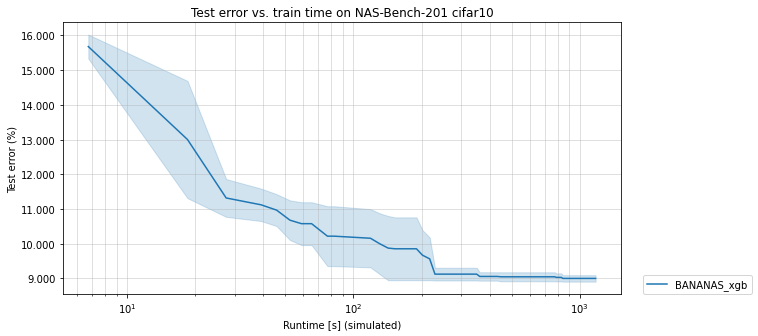

In [49]:
# Plot Bananas (xgb predictor), RS and RE
plot_optimizers(trajectories_bn,"NAS-Bench-201 cifar10")

### TASK 3: BANANAS with predictor of your choice
1. Choose any predictor from amongst `'mlp','lgb', 'rf','bayes_lin_reg','gp'` and run search using BANANAS
2. Use NASBench201 search space for the ImageNet16-120 dataset
3. Plot your results

In [ ]:
trajectories_bn_imgnet={}

In [ ]:
# Bananas with any other predictor of your choice
from naslib.search_spaces.core.query_metrics import Metric
from naslib import utils
from naslib.utils import get_dataset_api
from naslib.utils.logging import setup_logger
import os
import logging
import sys
from naslib.defaults.trainer import Trainer
from naslib.optimizers import (
    DARTSOptimizer,
    GDASOptimizer,
    DrNASOptimizer,
    RandomSearch,
    RegularizedEvolution,
    LocalSearch,
    Bananas,
    BasePredictor,
)
import json
from naslib.search_spaces import (
    NasBench301SearchSpace,
    SimpleCellSearchSpace,
    NasBench201SearchSpace,
    HierarchicalSearchSpace,
)

from fvcore.common.config import CfgNode
optimizer_type = Bananas # {RegularizedEvolution, RandomSearch}
search_space_type = ... # Specify the search space

# Set the dataset
dataset = ... # Specify the dataset

predictor = ... # Specify the predictor
for seed in [333,444,555]:
  config = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,
        
        # Required by Random Search optimizer
        'fidelity': -1,
        'k':20,
        "num_init":10,
        "num_ensemble":1,
        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
        "predictor_type": predictor,
        "acq_fn_type": "its",
        "acq_fn_optimization": 'random_sampling',
        "encoding_type": 'path',
        "num_arches_to_mutate":5,
        "max_mutations":1,
        "num_candidates":100
     }
   }
  config = CfgNode.load_cfg(json.dumps(config))

  search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                        optimizer_type,
                                                        search_space_type,
                                                        dataset,
                                                        '',
                                                        config,
                                                        seed
                                                    )
  if predictor in trajectories_bn_imgnet.keys():
    trajectories_bn_imgnet[predictor].append(search_trajectory)
  else: 
    trajectories_bn_imgnet[predictor] = []
    trajectories_bn_imgnet[predictor].append(search_trajectory)
  

In [ ]:
plot_optimizers(trajectories_bn_imgnet,'NAS-Bench201_ImageNet16-120')

<a name="zcps"></a>
# 4. Zero Cost Proxies

Zero Cost proxies allow us to *rank* models using only a single forward and backward pass of the data. Since they require much less time and compute to score models (as opposed to training them from scratch and comparing them, for example), they can be used as a cheap *proxy* to speed up black-box optimizers.

In this section, we look how we can use one of the 13 Zero Cost proxies available in NASLib to *score* a model. Intuitively, the higher the score of a model, the better we expect the model to perform (this isn't always true, though - there are cases where the scores are anti-correlated with the validation performance).

A perfect Zero Cost proxy would be one where its scores for models are perfectly correlated with the performance of those models, i.e., the ranking of the models by the Zero Cost proxies are the same as their ranking after they have been fully trained and evaluated.

In [22]:
from naslib.predictors import ZeroCost
from naslib.search_spaces import NasBench201SearchSpace
from naslib.utils import get_train_val_loaders, get_project_root
from fvcore.common.config import CfgNode
from tqdm import tqdm

# Create configs required for get_train_val_loaders
config = {
    'dataset': 'cifar10', # Dataset to loader: can be cifar100, svhn, ImageNet16-120, jigsaw, class_object, class_scene, or autoencoder (the last four are TNB101 datasets)
    'data': str(get_project_root()) + '/data', # path to naslib/data
    'search': {
        'seed': 9001, # Seed to use in the train, validation and test dataloaders
        'train_portion': 0.7, # Portion of train dataset to use as train dataset. The rest is used as validation dataset.
        'batch_size': 80, # batch size of the dataloaders
    }
}
config = CfgNode(config)

# Get the dataloaders
train_loader, val_loader, test_loader, train_transform, valid_transform = get_train_val_loaders(config)

# Sample a random NB201 graph and instantiate it
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
graph.parse()

# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
# {'epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params'}

zc_pred = 'monet'
zc_predictor = ZeroCost(method_type=zc_pred)
score = zc_predictor.query(graph=graph, dataloader=train_loader)

print(f'Score of model for Zero Cost predictor {zc_pred}: {score}')


Score of model for Zero Cost predictor monet: 0.9249785542488098


Let's now try scoring the same model with all the Zero Cost proxies. Remember that it only makes sense to compare between the scores of different models of a given proxy.

In [23]:
# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
zc_predictors = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params', 'monet']

print('Scores of model')
for zc_pred in zc_predictors:
    zc_predictor = ZeroCost(method_type=zc_pred)
    score = zc_predictor.query(graph=graph, dataloader=train_loader)
    print(f'{zc_pred}: {score:3f}')

Scores of model
epe_nas: 853.197757


C:\Users\T0300661\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fisher: 0.002183
grad_norm: 2.120457
grasp: -0.211671
jacov: -12296.159445
l2_norm: 78.702911
nwot: 747.248855
plain: 0.065569
snip: 4.367779
synflow: 25.137885
zen: 25.302025
flops: 14.886592
params: 0.101306
monet: 1.055234


Now that we have seen all the Zero Cost proxies in action, let's compute the *rank correlation* between the proxy scores of a few models and their validation performance. The higher the correlation, the better the proxy.

In [25]:
from naslib.search_spaces.core import Metric
from naslib.utils import compute_scores, get_dataset_api

# Sample 50 random architectures, query their performances
n_graphs = 5000
models = []
val_accs = []
zc_scores_monet = []
zc_scores_synflow = []
zc_scores_nwot = []

print('Loading NAS-Bench-201 API...')
api = get_dataset_api('nasbench201', 'cifar10')

print(f'Sampling {n_graphs} NAS-Bench-201 models...')
for _ in tqdm(range(n_graphs)):
    graph = NasBench201SearchSpace()
    graph.sample_random_architecture()
    graph.parse()

    models.append(graph)

zc_predictor_monet = ZeroCost(method_type="monet")
zc_predictor_synflow = ZeroCost(method_type="synflow")
zc_predictor_nwot = ZeroCost(method_type="nwot")

print('Querying validation performance and scores for all models')
for graph in tqdm(models):
    acc = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=api)
    val_accs.append(acc)

    score_monet = zc_predictor_monet.query(graph=graph, dataloader=train_loader)
    zc_scores_monet.append(score_monet) 

    score_synflow = zc_predictor_synflow.query(graph=graph, dataloader=train_loader)
    zc_scores_synflow.append(score_synflow) 

    score_nwot = zc_predictor_nwot.query(graph=graph, dataloader=train_loader)
    zc_scores_nwot.append(score_nwot) 

# We now compute the correlation between val_accs (ground truth) and zc_scores (proxy scores)
correlations_monet = compute_scores(ytest=val_accs, test_pred=zc_scores_monet)
correlations_synflow = compute_scores(ytest=val_accs, test_pred=zc_scores_synflow)
correlations_nwot = compute_scores(ytest=val_accs, test_pred=zc_scores_nwot)

# Extract the results
# kendalltau_corr = correlations['kendalltau']
# spearman_corr = correlations['spearman']
# pearson_corr = correlations['pearson']

corr_monet = correlations_monet["spearman"]
corr_synflow = correlations_synflow["spearman"]
corr_nwot = correlations_nwot["spearman"]

print('Correlations between validation accuracies (ground truth) and Zero Cost predictor scores (prediction): ')
print('Spearman correlation MONET :', corr_monet)
print('Spearman correlation SYNFLOW :', corr_synflow)
print('Spearman correlation NASWOT :', corr_nwot)

Querying validation performance and scores for all models


  0%|          | 0/5000 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000222337ABA90>>
Traceback (most recent call last):
  File "C:\Users\T0300661\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000222337ABA90>>
Traceback (most recent call last):
  File "C:\Users\T0300661\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


## Zero Cost Proxy Benchmarks

Much like NAS-Benchmark APIs, we have introduced Zero Cost Benchmark APIs, which lets you query instantly the Zero Cost proxy scores for a given model in a search space. Once again, the idea is to speed-up NAS research. If a black-box optimizer you want to write leverages Zero Cost proxies, for example, you could leverage the Zero Cost Benchmarks to run the experiments much faster by simply querying them for the scores instead of the scoring the models using the Zero Cost proxies.

We have already downloaded the Zero Cost Benchmark API for NAS-Bench-201, which has the scores for all 15625 models evaluated for all three datasets (CIFAR-10, CIFAR-100 and ImageNet16-120) using all 13 Zero Cost proxies.

Let's now query the benchmark API

In [6]:
from naslib.utils import get_zc_benchmark_api

# Load the Zero Cost Benchmark API for NAS-Bench-201 CIFAR-10
zc_api = get_zc_benchmark_api('nats', 'cifar10')
graph = models[0]

# Use the Zero Cost Benchmark to get the score for the model for a particular ZC proxy
pred = 'grasp'
spec = graph.get_hash()
score = zc_api[str(spec)][pred]['score']
time_to_compute = zc_api[str(spec)][pred]['time']

print(f'All the data available in the Zero Cost benchmark for model {spec}: ')
print(zc_api[str(spec)][pred])
print(f'Score of model with spec {spec} for Zero Cost proxies {pred}: {score}')
print(f'Time taken to compute the score for the model: {time_to_compute:.2f}s')

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\T0300661\\Desktop\\NASLib-Develop\\tutorial\\..\\naslib\\data\\zc_nats.json'

In [54]:
zc_scores = {pred: [] for pred in zc_predictors} # Just dictionary of an empty list for each predictor
print('zc_scores:', zc_scores)

print('Querying Zero Cost Benchmark for scores')
for graph in tqdm(models):
    spec = graph.get_hash()

    # Get the score for this model for all the Zero Cost proxies
    for pred in zc_predictors:
        score = zc_api[str(spec)][pred]['score']
        zc_scores[pred].append (score)

# Print the Zero Cost values for the first 5 models
for pred in zc_predictors:
    print(pred, zc_scores[pred][:5])

kt_corrs = {}
# Compute the rank correlation for each of the predictors
for pred in zc_predictors:
    correlations = compute_scores(ytest=val_accs, test_pred=zc_scores[pred])
    kendalltau_corr = correlations['kendalltau']
    kt_corrs[pred] = kendalltau_corr

print('Kendall-Tau correlations for all the predictors:')
print(kt_corrs)
# Sort the predictors from best to worst for these models
kt_corrs_list = [(pred, score) for pred, score in kt_corrs.items()]
kt_corrs_list = sorted(kt_corrs_list, reverse=True, key=lambda pred_score_tuple: pred_score_tuple[1])

print('ZC predictors ranked (best to worst):')
for idx, (pred, score) in enumerate(kt_corrs_list):
    print(f'#{idx+1}', pred, score)

100%|██████████| 50/50 [00:00<00:00, 8909.64it/s]

zc_scores: {'epe_nas': [], 'fisher': [], 'grad_norm': [], 'grasp': [], 'jacov': [], 'l2_norm': [], 'nwot': [], 'plain': [], 'snip': [], 'synflow': [], 'zen': [], 'flops': [], 'params': []}
Querying Zero Cost Benchmark for scores
epe_nas [1292.8213521234534, 1677.4133181362522, 771.6244256973021, 1737.454440152671, 1573.3680969091486]
fisher [0.0032408733386546373, 0.6351345181465149, 0.036273304373025894, 0.04645204544067383, 1.5173672437667847]
grad_norm [1.9650213718414307, 72.5101547241211, 7.580556869506836, 16.29119300842285, 126.30833435058594]
grasp [-0.016125619411468506, -3.2642059326171875, -0.06577873229980469, 4.319438457489014, 157.290771484375]
jacov [-72.90912838633159, -65.15828505076317, -311.63863660167726, -65.98522306098099, -65.11022856424916]
l2_norm [129.5747528076172, 231.27603149414062, 78.764892578125, 180.98062133789062, 282.43365478515625]
nwot [756.8241446485636, 789.6434823031072, 611.1394665263265, 782.2980597435335, 818.9739002527507]
plain [0.0644750222

# Bonus Challenge: Awesome Optimizer

Blazed through the tutorial? Want an extra challenge?

We ask you to write a black box optimizer that beats the RandomSearch baseline for NAS-Bench-201 for CIFAR-10, CIFAR-100 and ImageNet16-120 datasets.

Given below is the skeletal code for a NASLib Black-box optimizer, with everything except its main method - new_epoch() - filled. This method is called in every step of the search of the Trainer (as seen in the run_optimizer function before) and is responsible for executing the main logic of the optimizer. E.g., the Random-Search optimizer samples a random architecture and queries its validation performance here.

Remember that every query of a NAS-Benchmark for its validation performance is a substitute for training the model from scratch and evaluating its performance.

In this challenge, there is only one rule: **You may query the validation performance of only ONE model in new_epoch()**. 

i.e., only one model shall be evaluated in every call of new_epoch(). Feel free to sample several models, and rank them, and query only the best model, for example. You are free to implement your own ideas here.

In [ ]:
import torch

from fvcore.common.config import CfgNode

from naslib.optimizers.core.metaclasses import MetaOptimizer
from naslib.predictors.zerocost import ZeroCost
from naslib.search_spaces.core.graph import Graph
from naslib.search_spaces.core.query_metrics import Metric
from naslib.utils import get_train_val_loaders

# Import whatever else you want from NASLib

class AwesomeOptimizer(MetaOptimizer):
    """
    Implement your awesome optimizer here.

    This optimizer inherits from RandomSearch purely for convenience. Your search
    method does not have to be random at all. Feel free to write your own logic, and add 
    any new methods that you need for it.
    """

    def __init__(self, config: CfgNode):
        """
        Initialize your optimizer

        Args:
            config
        """
        super(AwesomeOptimizer, self).__init__()
        # These two lists are required
        self.sampled_archs = []
        self.history = []
        
        self.performance_metric = Metric.VAL_ACCURACY
        # You can add more properties to the config file and read them if you want
        self.dataset = config.dataset
        self.fidelity = config.search.fidelity

        # A few things that might be useful to you. Add/remove code as you wish.
        self.trainloader = get_train_val_loaders(config)[0]
        self.zerocostpredictor = ZeroCost(method_type='l2_norm')
        # self.my_awesome_property = config.my_awesome_property

        ###########################################################
        ##################### START TODO ##########################


        # Need more stuff in your initializer? Write them here!


        ##################### END TODO  ##########################
        ##########################################################


    def adapt_search_space(self, search_space: Graph, scope: str = None, dataset_api: dict = None):
        """
        This method has to be called with the search_space and the nas benchmark api before the optimizer
        can be used.

        Args:
            search_space : An instance of the search space, such as NasBench201SearchSpace()
            scope        : Relevant only for one-shot optimizers
            dataset_api  : NAS Benchmark API for the given search space
        """
        self.search_space = search_space.clone()
        self.dataset_api = dataset_api


    def new_epoch(self, epoch: int):
        """
        This method is called in every "step" of the search.

        Args:
            epoch: epoch number
        """

        # For reference, this is the code inside new_epoch in RandomSearch:

        # model = torch.nn.Module()
        # model.arch = self.search_space.clone()
        # model.arch.sample_random_architecture(dataset_api=self.dataset_api)
        # model.accuracy = model.arch.query(
        #     self.performance_metric,
        #     self.dataset,
        #     epoch=self.fidelity,
        #     dataset_api=self.dataset_api,
        # )
        # self.sampled_archs.append(model)
        # self._update_history(model)

        # All it does 

        ###########################################################
        ##################### START TODO ##########################


        # Write your logic here
        # Also feel free to write new methods in this class


        ##################### END TODO  ##########################
        ##########################################################

        self.sampled_archs.append(model) # This line is required. Add your chosen model to sampled_archs here.

    def get_final_architecture(self):
        """
        Returns the sampled architecture with the lowest validation error.
        """
        return max(self.sampled_archs, key=lambda x: x.accuracy).arch

    def train_statistics(self, report_incumbent: bool = True):

        if report_incumbent:
            best_arch = self.get_final_architecture()
        else:
            best_arch = self.sampled_archs[-1].arch

        return (
            best_arch.query(
                Metric.TRAIN_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.VAL_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.TEST_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.TRAIN_TIME, self.dataset, dataset_api=self.dataset_api
            ),
        )

    def test_statistics(self):
        best_arch = self.get_final_architecture()
        return best_arch.query(Metric.RAW, self.dataset, dataset_api=self.dataset_api)

    def _update_history(self, child):
        """
            We want to maintain only the history of the 100 best models in self.history
            (self.sampled_archs stores the list of all models sampled.)
        """
        if len(self.history) < 100:
            self.history.append(child)
        else:
            for i, p in enumerate(self.history):
                if child.accuracy > p.accuracy:
                    self.history[i] = child
                    break

    def get_checkpointables(self):
        return {"models": self.history}
